# Plot data for each example

- Fingerprints for an optimized pose cluster
- Pair features for optimized pose cluster

In [1]:
import sys
import os
import numpy as np
sys.path.append('../')
from score.prob_opt import PredictStructs
from containers import Protein
from shared_paths import shared_paths
from score.density_estimate import DensityEstimate


import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

In [2]:
def read_settings(root):
    tr = {}
    with open('{}/settings.py'.format(root)) as f:
        for line in f:
            var,val = line.split('=')
            tr[var] = eval(val)
    return tr
            
def read_score_file(fname):
    """
    Returns a dictionary of {lig_name: pose, ...} stored
    in FNAME.
    """
    combind_cluster, best_cluster = {}, {}
    with open(fname) as fp:
        fp.readline()
        for line in fp:
            tok = line.strip().split(',')
            if len(tok) != 3:
                combind_cluster[tok[0]] = int(tok[1])
                best_cluster[tok[0]] = int(tok[5]) if tok[5] != 'None' else None
    return combind_cluster, best_cluster
            
def read_data(protein, shared_paths, pose_cluster):
    cwd = os.getcwd()
    data = Protein(protein)
    data.load_docking(list(set([lig for lig in pose_cluster])),
              load_mcss = False, load_fp = True)
    os.chdir(cwd)
    return data

def load(cluster_file, protein, root, stats_root):
    features = set('_'.join(fname[:-4].split('_')[1:])
                   for fname in os.listdir(root) if fname[-3:] == 'txt')

    stats = {'native':{}, 'reference':{}}
    for feature in features:
        for dist in stats:
            stats[dist][feature] = DensityEstimate.read('{}/{}_{}.txt'.format(root, dist, feature))

    settings = read_settings(root)
    combind_cluster, best_cluster = read_score_file("{}/{}".format(root, cluster_file))
    data = read_data(protein, shared_paths, combind_cluster)
    ps = PredictStructs(data, stats, settings['k_list'], 100, settings['alpha'])
    l_list = sorted(combind_cluster.keys(), reverse = True)
    combind_top = ps.get_poses(combind_cluster)
    glide_top   = ps.get_poses({l:0 for l in combind_cluster})
    return l_list, combind_top, glide_top

In [7]:
def get_interactions(l_list, combind_top, glide_top, feature_defs):
    print(feature_defs)
    interactions = sorted(set([interaction
                               for pose in list(combind_top.values())+list(glide_top.values())
                               for interaction in pose.fp.keys()
                               if (interaction[0] in [idx for idxs in feature_defs.values() for idx in idxs])]))
    # All poses to get indices
    X = np.zeros((2*len(glide_top), len(interactions)))
    for i, lig in enumerate(l_list):
        for j, interaction in enumerate(interactions):
            if interaction in combind_top[lig].fp:
                X[2*i+1, j] = combind_top[lig].fp[interaction]
            if interaction in glide_top[lig].fp:
                X[2*i+0, j] = glide_top[lig].fp[interaction]
    return interactions, X#[:, indices]

def format_int(interaction):
    three_to_one = {
        'TYR': 'Y',
        'VAL': 'V',
        'ARG': 'R',
        'THR': 'T',
        'GLU': 'E',
        'SER': 'S',
        'PHE': 'F',
        'ALA': 'A',
        'MET': 'M',
        'ILE': 'I',
        'ASP': 'D',
        'GLN': 'Q',
        'ASN': 'N',
        'GLY': 'G',
        'PRO': 'P',
        'TRP': 'W',
        'LEU': 'L',
        'LYS': 'K',
        'CYS': 'C',
        'HIS': 'H'
    }
    name = interaction.split('(')[1][:-1]
    num = interaction.split('(')[0].split(':')[1]
    return three_to_one[name] + num

def pretty(labels, divide, resname_size):
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    for axis in ['x', 'y']:
        plt.tick_params(axis=axis, which='both',bottom=False,top=False, left=False, right =False)
    plt.yticks(range(0, divide*len(labels), divide), labels,
               size = resname_size, fontname = 'monospace')
    plt.xticks(range(0, divide*len(l_list), divide),
               [lig.replace('_lig', '') if not '5IRX' in lig else 'Resiniferatoxin'
                for lig in l_list],
               rotation = 'vertical', size = resname_size, fontname = 'monospace')
    #plt.colorbar()
    plt.show()

def gel_plot(combind, glide, labels, divide, resname_size):
    seen = combind + glide
    diff = combind - glide

    # Remove interactions that are never seen.
    X = diff[seen.sum(axis = 1) > 0]
    labels = np.array(labels)[seen.sum(axis = 1) > 0]
    seen = seen[seen.sum(axis = 1) > 0]
    
    # Differentiate values that are the same and
    # positive from those that are zero.
    X[seen == 0] = float('inf')
    
    # Y is X + empty cells seperating boxes.
    Y = np.zeros((X.shape[0]*divide, X.shape[1]*divide))
    Y.fill(float('inf')) # dividers should be white.
    Y[::divide, ::divide] = X

    from matplotlib import colors
    rkb = [(1, 0, 0.5), (0, 0, 0), (0.5, 1, 0)]
    cm = LinearSegmentedColormap.from_list('rkb', rkb, N=256, gamma=1.0)
    plt.figure(figsize = (5, 5))
    plt.imshow(Y, cm, aspect = 'auto', vmin=-0.5, vmax=0.5)
    pretty(labels, divide, resname_size)
    
def pretty_imshow(X, labels, divide, resname_size):
    # Remove interactions that are never seen.
    plt.figure(figsize = (5, 5))
    labels = np.array(labels)[X.sum(axis = 1) > 0]
    X = X[X.sum(axis = 1) > 0]
    
    # Y is X + empty cells seperating boxes.
    Y = np.zeros((X.shape[0]*divide, X.shape[1]*divide))
    Y[::divide, ::divide] = X

    plt.imshow(Y, cmap='binary', aspect = 'auto')
    pretty(labels, divide, resname_size)
    
def plot(l_list, combind_top, glide_top, feature_defs, divide = 2, resname_size = 14):
    interactions, X = get_interactions(l_list, combind_top, glide_top, feature_defs)
    idx = np.argsort(X.sum(axis = 0))[::-1]
    interactions = np.array(interactions)[idx]
    X = X[:, idx]
    interactions = [format_int(l[1]) for l in interactions]
    combind = X[range(1, 2*len(l_list), 2)].T
    glide = X[range(0, 2*len(l_list), 2)].T
    gel_plot(combind, glide, interactions, divide, resname_size)
    print('combind')
    pretty_imshow(combind, interactions, divide, resname_size)
    print('glide')
    pretty_imshow(glide, interactions, divide, resname_size)

In [4]:
protein = 'TRPV1'
scores = 'stats7/best_affinity/standard/10-1.0-mcss_contact_hbond_sb'
cluster_file = '5IRX_lig-to-3J5Q.sc'

root = '{}/{}/scores/{}'.format(shared_paths['data'], protein, scores)
stats_root = '{}/{}/scores/{}'.format(shared_paths['data'], protein, 'stats6/stats')
l_list, combind_top, glide_top = load(cluster_file, protein, root, stats_root)

{'hbond': [2, 3]}


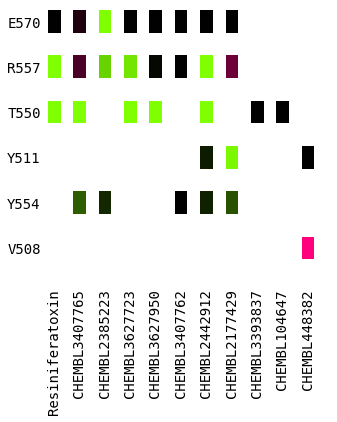

combind


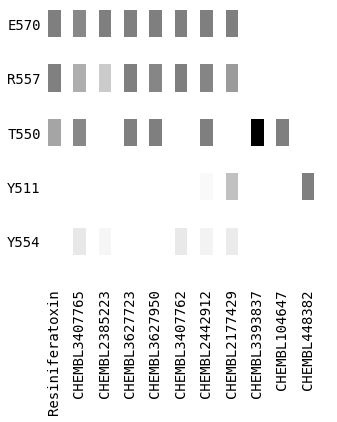

glide


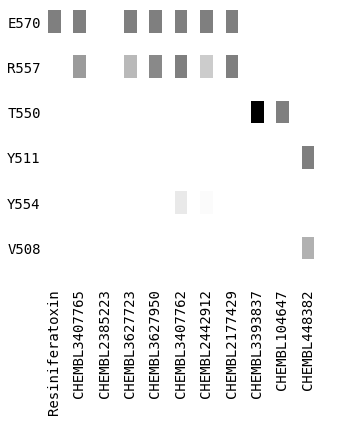

In [8]:
feature_defs = {
    'hbond':[2,3],
    #'sb2':[1],
    #'pipi':[6],
    #'contact':[11]
}

l_list = ['5IRX_lig',
          'CHEMBL3407765_lig', 'CHEMBL2385223_lig', 'CHEMBL3627723_lig',
          'CHEMBL3627950_lig', 'CHEMBL3407762_lig', 'CHEMBL2442912_lig',
          'CHEMBL2177429_lig', 'CHEMBL3393837_lig', 'CHEMBL104647_lig', 'CHEMBL448382_lig', ]
plot(l_list, combind_top, glide_top, feature_defs)

In [9]:
protein = 'B1AR'
scores = 'stats6/pdb/standard/1.0-mcss_contact_hbond_sb'
cluster_file = 'pdb.sc'

root = '{}/{}/scores/{}'.format(shared_paths['data'], protein, scores)
stats_root = '{}/{}/scores/{}'.format(shared_paths['data'], protein, 'stats6/stats')
l_list, combind_top, glide_top = load(cluster_file, protein, root, stats_root)

{'hbond': [2, 3], 'sb': [1]}


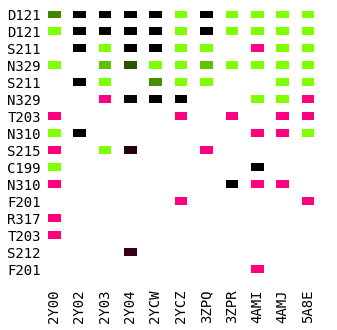

combind


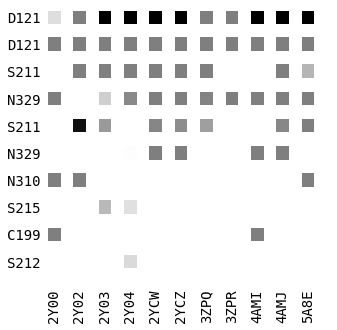

glide


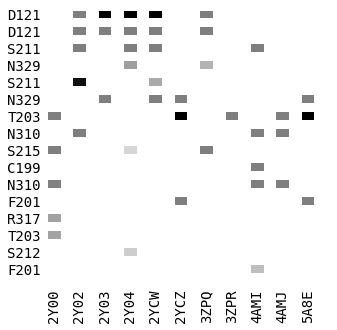

{'hbond': [2, 3]}


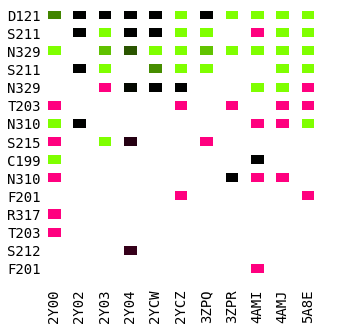

combind


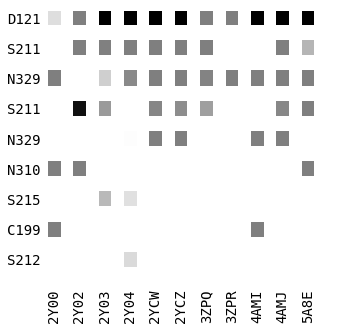

glide


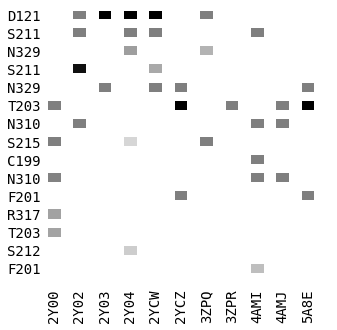

In [15]:
feature_defs = {
    'hbond':[2,3],
    'sb':[1],
    #'pipi':[6],
    #'contact':[11]
}

l_list = list(combind_top.keys())
plot(l_list, combind_top, glide_top, feature_defs)

feature_defs = {
    'hbond':[2,3],
    #'sb':[1],
    #'pipi':[6],
    #'contact':[11]
}

plot(l_list, combind_top, glide_top, feature_defs)

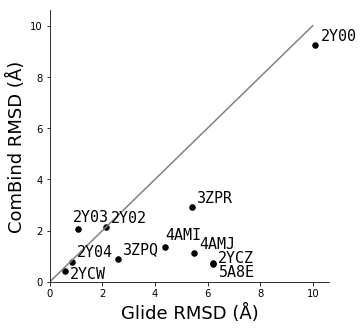

In [16]:
combind_rmsds = [combind_top[lig].rmsd for lig in l_list]
glide_rmsds = [glide_top[lig].rmsd for lig in l_list]
f, ax = plt.subplots(figsize = (5, 5))
ax.scatter(glide_rmsds, combind_rmsds, s = 30, c = 'k')
ax.plot(range(11), c = 'grey')


for x, y, lig in zip(glide_rmsds, combind_rmsds, l_list):
    x_shift, y_shift = 0.2, 0.2
    if lig == '2YCW_lig':
        x_shift, y_shift = 0.2, -0.3
    if lig == '2Y03_lig':
        x_shift, y_shift = -0.2, 0.3
    if lig == '4AMI_lig':
        x_shift, y_shift = 0, 0.3
    if lig == '5A8E_lig':
        x_shift, y_shift = 0.2, -0.5
    if lig == '2YCZ_lig':
        x_shift, y_shift = 0.2, 0.05
        
    ax.text(x+x_shift, y+y_shift, lig.replace('_lig', ''), size = 15, name = 'monospace')


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlim(0)
ax.set_ylim(ax.get_xlim())

ax.set_ylabel('ComBind RMSD (Å)', size = 18)
ax.set_xlabel('Glide RMSD (Å)', size = 18)
plt.show()